## Unir y preparar los ficheros bajados de IVIMA.

Los datos del IVIMA hay que bajarlos manualmente desde: http://www.planalquila.org/

In [1]:
## Imports y directorios in/out

import pandas as pd
import os
import numpy as np

input_dir = '../../data/raw/IVIMA/'
out_dir = '../../data/clean/IVIMA/'
aux_dir = '../../data/raw/OTROS/'


input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

out_file = os.path.join(input_dir, 'ivima_cat.csv')
!rm $out_file
!touch $out_file

for f in input_files:
    if f <> out_file:
        !cat $f >> $out_file

rawdata = pd.read_csv(out_file, sep='\t')

# Eliminar columnas no útiles
rawdata.drop(['Foto', 'Ref.', 'Fecha oferta', 'Unnamed: 9'], axis=1, inplace=True)

# Eliminar duplicados
rawdata = rawdata.drop_duplicates()

# Damos nombres "normales" a las columnas
rawdata.rename(columns={'Dirección':'Direccion', 'm²':'metros', 'Nºhab.':'habitaciones'}, inplace=True)

# Eliminar filas sin datos en predictores (Planta, m2, Precio)

rawdata = rawdata.dropna(subset=['Planta', 'metros','Precio'])

# Marcar garage 1=Si, 0=No
rawdata['Garaje']=rawdata.apply(lambda x: 1 if x['Garaje'] == 'si' else 0, axis = 1)

# al concatenar se han quedado los encabezados como datos, los eliminamos

rawdata = rawdata[rawdata['Precio'] != 'Precio']

# Convertir a tipo de dato correcto: metros y €

rawdata['Precio'] = rawdata['Precio'].str.replace(',', '.').str.replace('€', '').str.strip()

rawdata['Precio'] = rawdata['Precio'].map(float)

rawdata['metros'] = rawdata['metros'].str.replace(',', '.').str.strip()

rawdata['metros'] = rawdata['metros'].map(float)

In [2]:
# Analizamos los datos de € y metros que van a condicionar el modelo

In [3]:

rawdata['eur_metro'] = (rawdata['Precio']/rawdata['metros'])
rawdata['eur_metro_round'] = rawdata['eur_metro'].apply(lambda x: round(x, ndigits = 1))


In [4]:
rawdata.describe()

,metros,Garaje,Precio,eur_metro,eur_metro_round
count,5656.000000,5656.000000,5656.000000,5656.000000,5656.000000
mean,59.490818,0.190240,691.777801,12.563874,12.563543
std,55.835065,0.392525,188.677759,3.908525,3.908971
min,6.470000,0.000000,300.000000,0.120633,0.100000
25%,45.000000,0.000000,570.000000,9.992006,10.000000
50%,56.450000,0.000000,650.000000,11.791749,11.800000
75%,70.000000,0.000000,750.000000,14.285714,14.300000
max,3979.000000,1.000000,2500.000000,85.007728,85.000000


In [5]:
## La std de los metros es demasiado alta, además el máximo son 3979 m, demasiado para una vivienda

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)


In [7]:
%matplotlib inline

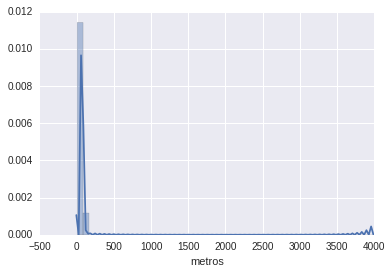

In [8]:
sns.distplot(rawdata['metros'])
plt.show()

In [9]:
rawdata[rawdata['metros']>200]

,Direccion,Planta,metros,habitaciones,Garaje,Precio,eur_metro,eur_metro_round
3781,"CALLE AMPARO, 12",4,335.0,2,0,685.0,2.044776,2.0
4815,"CALLE CARABIAS, 20",2,3979.0,2,0,480.0,0.120633,0.1


In [10]:
#Hay 2 valores que parecen errores de datos, los eliminamos

In [11]:
rawdata.drop(rawdata[rawdata['metros']>200].index, inplace=True)

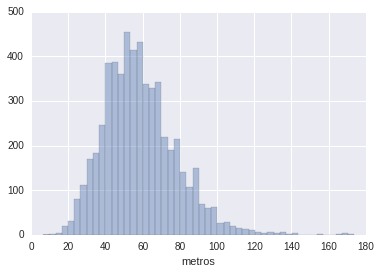

In [12]:
sns.distplot(rawdata['metros'], kde=False)
plt.show()

In [13]:
rawdata.describe()

,metros,Garaje,Precio,eur_metro,eur_metro_round
count,5654.000000,5654.000000,5654.000000,5654.000000,5654.000000
mean,58.748862,0.190308,691.816456,12.567935,12.567616
std,19.674518,0.392579,188.690085,3.903203,3.903617
min,6.470000,0.000000,300.000000,5.633803,5.600000
25%,45.000000,0.000000,570.000000,9.995226,10.000000
50%,56.425000,0.000000,650.000000,11.794593,11.800000
75%,70.000000,0.000000,750.000000,14.285714,14.300000
max,173.870000,1.000000,2500.000000,85.007728,85.000000


In [14]:
## Estudiamos los valores de euros

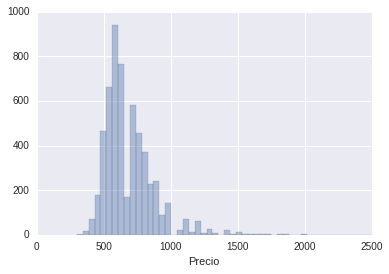

In [15]:
sns.distplot(rawdata['Precio'], kde=False)
plt.show()

In [16]:
rawdata[rawdata['Precio']>1800]

,Direccion,Planta,metros,habitaciones,Garaje,Precio,eur_metro,eur_metro_round
1099,"CALLE DOCTOR FLEMING, 11",2,165.60225,5,0,2500.0,15.096413,15.1
1177,"CALLE POTOSI, 4",4,110.91000,3,1,1850.0,16.680191,16.7
3915,"CALLE JESUS, 2",2,157.00000,3,0,2000.0,12.738854,12.7
4101,"CUESTA DE SANTO DOMINGO, 22",3,173.00000,4,0,2000.0,11.560694,11.6
4681,"CALLE LAGASCA, 95",3,103.00000,3,0,1850.0,17.961165,18.0


In [17]:
## Los valores de precio no parecen presentar problemas

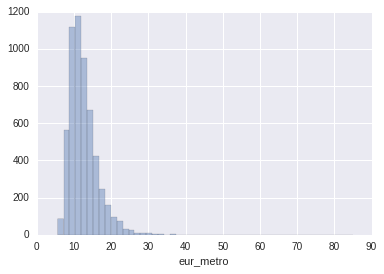

In [18]:
sns.distplot(rawdata['eur_metro'], kde=False)
plt.show()

In [19]:
# Traducir los valores de planta a los que existen en catastro para que el modelo se pueda
# aplicar a los datos reales
planta_ivima = pd.DataFrame((rawdata['Planta'].value_counts()).reset_index())

In [20]:
planta_ivima.rename(columns={'index':'planta', 'Planta':'elementos'}, inplace=True)

In [21]:
planta_ivima

,planta,elementos
0,1,1094
1,2,1067
2,3,990
3,4,695
4,5,330
5,BAJO,262
6,6,216
7,BJ,168
8,7,126
9,8,87


In [22]:
## Para cada planta de IVIMA hay que asociar el equivalente en catastro

In [23]:
## Añadimos una columna para buscar en catastro quitando los caracteres que no sean
# números ni letras 'º', asi tendremos los números

In [24]:
caracter_raro = planta_ivima[planta_ivima['planta'].str.contains('\W+')]['planta'].str.extract('(\W+)').unique()

/home/manu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [25]:
caracter_raro

array(['\xc2\xba', '/', '-', ' ', '\xc2\xba '], dtype=object)

In [26]:
planta_ivima['planta_busqueda'] = planta_ivima['planta']

for raro in caracter_raro:
    planta_ivima['planta_busqueda'] = planta_ivima['planta_busqueda'].str.replace(raro, '')

In [27]:
##planta_ivima['planta_busqueda'] = planta_ivima['planta'].str.replace('º', '')

In [28]:
## La codificación de planta en catastro es de 2 caracteres

In [29]:
planta_ivima['planta_busqueda'] = planta_ivima['planta_busqueda'].apply(lambda x: '0' + x if len(x)==1 else x)

In [30]:
clean_dir = '../../data/clean/ficheros_preparados/'

In [31]:
cat_data =  pd.read_csv(os.path.join(clean_dir, 'BI_28_900_U_2016-01-23.csv.gz'), low_memory=False, dtype='str')

In [32]:
# Solo estamos interesados en los bienes inmuebles del tipo vivienda
planta_cat = pd.DataFrame(cat_data[cat_data['clave_grupo_BI']=='V']['planta'].value_counts().reset_index())

In [33]:
planta_cat.rename(columns={'index':'planta_cat', 'planta':'elementos'}, inplace=True)

In [34]:
# Poblamos en plantas ivima los cruces directos

In [35]:
planta_ivima = pd.merge(planta_ivima, planta_cat, how='left', left_on='planta_busqueda', right_on='planta_cat', suffixes=('ivi', 'cat'))

In [36]:
## Exportamos la tabla para revisión manual de las asociaciones que no cruzan directamente

In [37]:
planta_ivima.to_csv(os.path.join(aux_dir, 'plantas_ivima.csv'))

In [38]:
planta_ivima_revisada = pd.read_csv(os.path.join(out_dir, 'plantas_ivima.csv'), sep=';', index_col=0)

In [39]:
planta_ivima_revisada = planta_ivima_revisada.drop(['planta', 'elementosivi', 'planta_busqueda', 'elementoscat'], axis=1)

In [40]:
planta_ivima = pd.merge(planta_ivima, planta_ivima_revisada, left_index=True, right_index=True)

In [41]:
planta_ivima = planta_ivima.drop(['planta_busqueda', 'planta_cat_x', 'elementoscat', 'elementosivi'], axis=1)

In [42]:
planta_ivima.head()

,planta,planta_cat_y
0,1,01
1,2,02
2,3,03
3,4,04
4,5,05


In [43]:
planta_ivima.rename(columns={'planta':'Planta', 'planta_cat_y':'planta_cat'}, inplace=True)

In [44]:
# poblamos los literales de planta de catastro en la tabla de datos

In [45]:
rawdata.head()

,Direccion,Planta,metros,habitaciones,Garaje,Precio,eur_metro,eur_metro_round
0,"AVENIDA DE MORATALAZ, 103",2,85.00,3,0,850.0,10.000000,10.0
1,"AVENIDA DE MORATALAZ, 29",4,41.67,2,0,600.0,14.398848,14.4
2,"AVENIDA DE MORATALAZ, 73",3,55.00,3,0,620.0,11.272727,11.3
3,"AVENIDA DE MORATALAZ, 85",BAJO,54.60,3,0,650.0,11.904762,11.9
5,"AVENIDA DOCTOR GARCIA TAPIA, 102",BJ,43.50,2,0,600.0,13.793103,13.8


In [46]:
rawdata = pd.merge(rawdata, planta_ivima, how='left', left_on='Planta', right_on='Planta')

In [47]:
rawdata.head()

,Direccion,Planta,metros,habitaciones,Garaje,Precio,eur_metro,eur_metro_round,planta_cat
0,"AVENIDA DE MORATALAZ, 103",2,85.00,3,0,850.0,10.000000,10.0,02
1,"AVENIDA DE MORATALAZ, 29",4,41.67,2,0,600.0,14.398848,14.4,04
2,"AVENIDA DE MORATALAZ, 73",3,55.00,3,0,620.0,11.272727,11.3,03
3,"AVENIDA DE MORATALAZ, 85",BAJO,54.60,3,0,650.0,11.904762,11.9,BJ
4,"AVENIDA DOCTOR GARCIA TAPIA, 102",BJ,43.50,2,0,600.0,13.793103,13.8,BJ


In [48]:
# separamos la direccion en calle y número. Lo necesitaremos en R para buscar el año de la finca en el catastro

In [49]:
direcciones = rawdata['Direccion'].str.split(',', expand = True)

In [50]:
direcciones.drop(2, axis=1, inplace = True)

In [51]:
direcciones.rename(columns={0:'Calle', 1:'numero'}, inplace=True)

In [52]:
rawdata = pd.concat([rawdata, direcciones], axis = 1)

In [53]:
rawdata.head()

,Direccion,Planta,metros,habitaciones,Garaje,Precio,eur_metro,eur_metro_round,planta_cat,Calle,numero
0,"AVENIDA DE MORATALAZ, 103",2,85.00,3,0,850.0,10.000000,10.0,02,AVENIDA DE MORATALAZ,103
1,"AVENIDA DE MORATALAZ, 29",4,41.67,2,0,600.0,14.398848,14.4,04,AVENIDA DE MORATALAZ,29
2,"AVENIDA DE MORATALAZ, 73",3,55.00,3,0,620.0,11.272727,11.3,03,AVENIDA DE MORATALAZ,73
3,"AVENIDA DE MORATALAZ, 85",BAJO,54.60,3,0,650.0,11.904762,11.9,BJ,AVENIDA DE MORATALAZ,85
4,"AVENIDA DOCTOR GARCIA TAPIA, 102",BJ,43.50,2,0,600.0,13.793103,13.8,BJ,AVENIDA DOCTOR GARCIA TAPIA,102


In [54]:
pd.set_option('display.max_columns', None)

In [55]:
cat_data.head()

,cod_del_MEH,cod_muni_DGC,clase_BI,parcela_cat,num_cargo,num_fijo_BI,BI_ayunt,num_finca_registral,cprov,provincia,cmun_DGC,cmun_ine,municipio,entidad_menor,cvia_DGC,tipo_via,nombre_via,num_pol1,bis,num_pol2,bis2,Km,bloque,escalera,planta,puerta,dir_resto,cod_postal,distrito,antiguedad_BI,clave_grupo_BI,m2_BI,m2_solares_sin_div_hor,coef_finca,garage,num_orden_BI,aniot14,anio_mejor,x_coor,y_coor,huso_geo
0,28,900,UR,1965204VK4716F,0001,00257650,000000000255496,00000,28,MADRID,900,079,MADRID,NaN,01365,CL,CLAUDIO COELLO,0139,NaN,0000,NaN,00000,NaN,T,OD,OS,0000,28006,04,1975,G,0000021526,0000002321,100000000,0,NaN,0,1975,441827.64,4476294.63,25830
1,28,900,UR,9437605VK3793G,0001,81140056,000000000063083,00000,28,MADRID,900,079,MADRID,NaN,05269,CL,ROSARIO,0000,NaN,0000,NaN,00000,NaN,S,UE,LO,NaN,28005,01,0,M,0000000000,0000001150,100000000,0,NaN,0,0,439356.7,4473478.15,25830
2,28,900,UR,0148301VK4704G,0001,00001774,000000000079248,2810802002614,28,MADRID,900,079,MADRID,NaN,05859,CL,SILVA,0002,NaN,0000,NaN,00000,NaN,NaN,-4,01,NaN,28013,01,1984,A,0000000023,0000000631,000070000,0,NaN,0,1984,439945.24,4474677.58,25830
3,28,900,UR,0148301VK4704G,0002,00001775,000000000079249,2810802002616,28,MADRID,900,079,MADRID,NaN,05859,CL,SILVA,0002,NaN,0000,NaN,00000,NaN,NaN,-4,02,NaN,28013,01,1984,A,0000000023,0000000631,000070000,0,NaN,0,1984,439945.24,4474677.58,25830
4,28,900,UR,0148301VK4704G,0003,00001776,000000000079250,2810802002618,28,MADRID,900,079,MADRID,NaN,05859,CL,SILVA,0002,NaN,0000,NaN,00000,NaN,NaN,-4,03,NaN,28013,01,1984,A,0000000023,0000000631,000070000,0,NaN,0,1984,439945.24,4474677.58,25830


In [56]:
rawdata['numero']=rawdata['numero'].str.strip()
rawdata['Calle']=rawdata['Calle'].str.strip()

In [57]:
rawdata[rawdata['numero'].str.isdigit() == False]

,Direccion,Planta,metros,habitaciones,Garaje,Precio,eur_metro,eur_metro_round,planta_cat,Calle,numero
52,"CALLE CORREGIDOR DIEGO CABEZA DE VACA, 9B",4,61.190,2,1,650.00,10.622651,10.6,04,CALLE CORREGIDOR DIEGO CABEZA DE VACA,9B
172,"AVENIDA MONASTERIO DE SILOS, 80-A",1º,57.180,2,1,1000.00,17.488632,17.5,01,AVENIDA MONASTERIO DE SILOS,80-A
222,"CALLE CASTILLO DE CANDANCHU, 48 A",6,85.000,3,1,975.00,11.470588,11.5,06,CALLE CASTILLO DE CANDANCHU,48 A
541,"CALLE AMOS DE ESCALANTE, 7-9",1,54.000,1,0,700.00,12.962963,13.0,01,CALLE AMOS DE ESCALANTE,7-9
603,"CALLE ELFO, 78A",6,53.150,2,0,800.00,15.051740,15.1,06,CALLE ELFO,78A
611,"CALLE EMILIO GASTESI FERNANDEZ, 40-46",4º,80.290,3,0,750.00,9.341138,9.3,04,CALLE EMILIO GASTESI FERNANDEZ,40-46
683,"CALLE JOSE FELIU Y CODINA, 5 BIS",2,67.000,2,1,750.00,11.194030,11.2,02,CALLE JOSE FELIU Y CODINA,5 BIS
763,"CALLE RAFAEL BERGAMIN, 20B",3,52.920,1,0,680.00,12.849584,12.8,03,CALLE RAFAEL BERGAMIN,20B
903,"CALLE CALIZA, 8B",2,81.600,3,1,850.00,10.416667,10.4,02,CALLE CALIZA,8B
934,"CALLE LADERA DE LOS ALMENDROS, 12A",2,73.349,2,1,750.00,10.225088,10.2,02,CALLE LADERA DE LOS ALMENDROS,12A


In [58]:
# Sustituimos los nulos de número por ''

In [59]:
rawdata.loc[rawdata['numero'].isnull(), 'numero'] = ''

# Elimnar espacios del campo numero

rawdata['numero'] = rawdata['numero'].str.replace(' ', '')

In [60]:
# Analizamos el tipo de separador que hay en el campo 'numero'. (hay '-' y '/')

In [61]:
separadores = rawdata[rawdata['numero'].str.contains('\W+')]['numero'].str.extract('(\W+)').unique()

/home/manu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [62]:
separadores

array(['-', '/'], dtype=object)

In [63]:
for separador in separadores:
    rawdata['numero'] = rawdata['numero'].str.replace(separador, '-')
    

In [64]:
rawdata[rawdata['numero'].str.contains('\W+')]

,Direccion,Planta,metros,habitaciones,Garaje,Precio,eur_metro,eur_metro_round,planta_cat,Calle,numero
172,"AVENIDA MONASTERIO DE SILOS, 80-A",1º,57.18,2,1,1000.0,17.488632,17.5,01,AVENIDA MONASTERIO DE SILOS,80-A
541,"CALLE AMOS DE ESCALANTE, 7-9",1,54.00,1,0,700.0,12.962963,13.0,01,CALLE AMOS DE ESCALANTE,7-9
611,"CALLE EMILIO GASTESI FERNANDEZ, 40-46",4º,80.29,3,0,750.0,9.341138,9.3,04,CALLE EMILIO GASTESI FERNANDEZ,40-46
936,"CALLE LADERA DE LOS ALMENDROS, 18-D",3º,53.90,2,1,750.0,13.914657,13.9,03,CALLE LADERA DE LOS ALMENDROS,18-D
983,"CALLE SAN CIRPIRIANO, 50-52",4,74.00,3,0,750.0,10.135135,10.1,04,CALLE SAN CIRPIRIANO,50-52
1009,"CALLE AGUSTIN DE FOXA, 16-18",5,34.50,1,0,750.0,21.739130,21.7,05,CALLE AGUSTIN DE FOXA,16-18
1194,"PASEO DE LA HABANA, 148-150",4,63.00,2,0,900.0,14.285714,14.3,04,PASEO DE LA HABANA,148-150
1214,"AVENIDA DE LAS SUERTES, 67- E",4,75.30,3,1,850.0,11.288181,11.3,04,AVENIDA DE LAS SUERTES,67-E
1219,"AVENIDA DEL CERRO MILANO, 141 -143",1,46.00,1,1,590.0,12.826087,12.8,01,AVENIDA DEL CERRO MILANO,141-143
1261,"CALLE ALAMEDA DEL VALLE, 21-23",2,91.43,2,0,850.0,9.296730,9.3,02,CALLE ALAMEDA DEL VALLE,21-23


In [65]:
# Separamos en el número si hay parte de Bis/Duplicado

In [66]:
numeros_tratar = rawdata[rawdata['numero'].str.isdigit() == False]

In [67]:
# Tratamos de forma diferente si hay un - o no

In [68]:
numeros_guion = numeros_tratar[numeros_tratar['numero'].str.find('-') != -1]

In [69]:
numeros_guion.head()

,Direccion,Planta,metros,habitaciones,Garaje,Precio,eur_metro,eur_metro_round,planta_cat,Calle,numero
172,"AVENIDA MONASTERIO DE SILOS, 80-A",1º,57.18,2,1,1000.0,17.488632,17.5,01,AVENIDA MONASTERIO DE SILOS,80-A
541,"CALLE AMOS DE ESCALANTE, 7-9",1,54.00,1,0,700.0,12.962963,13.0,01,CALLE AMOS DE ESCALANTE,7-9
611,"CALLE EMILIO GASTESI FERNANDEZ, 40-46",4º,80.29,3,0,750.0,9.341138,9.3,04,CALLE EMILIO GASTESI FERNANDEZ,40-46
936,"CALLE LADERA DE LOS ALMENDROS, 18-D",3º,53.90,2,1,750.0,13.914657,13.9,03,CALLE LADERA DE LOS ALMENDROS,18-D
983,"CALLE SAN CIRPIRIANO, 50-52",4,74.00,3,0,750.0,10.135135,10.1,04,CALLE SAN CIRPIRIANO,50-52


In [70]:
## Separamos por el guion y en el segundo campo sustituimos BIS por B

In [71]:
num_bis_guion = numeros_guion['numero'].str.split('-', expand = True)

In [72]:
num_bis_guion.rename(columns = {0:'num_pol', 1:'letra'}, inplace=True)

In [73]:
num_bis_guion

,num_pol,letra
172,80,A
541,7,9
611,40,46
936,18,D
983,50,52
1009,16,18
1194,148,150
1214,67,E
1219,141,143
1261,21,23


In [74]:
# las letras no pueden ser números, vaciamos las que lo sean

In [75]:
num_bis_guion['letra'] = num_bis_guion['letra'].apply(lambda x: '' if x.isdigit() else x)

In [76]:
num_bis_guion['letra'] = num_bis_guion['letra'].replace('BIS', 'B')

In [77]:
# Tratamos los que no tienen -

In [78]:
numeros_no_guion = numeros_tratar[numeros_tratar['numero'].str.find('-') == -1]

In [79]:
numeros_no_guion = numeros_no_guion.drop(numeros_no_guion.columns[:-1], axis=1)

In [80]:
numeros_no_guion['numero'] = numeros_no_guion['numero'].str.replace('BIS', 'B')

In [81]:
numeros_no_guion.head()

,numero
52,9B
222,48A
603,78A
683,5B
763,20B


In [82]:
numeros_no_guion['num_pol'] = numeros_no_guion['numero'].str.extract('(\d+)', expand = True)

In [83]:
numeros_no_guion['letra'] = numeros_no_guion['numero'].str.extract('(\D+)', expand = True)

In [84]:
numeros_no_guion.drop('numero', axis=1, inplace=True)

In [85]:
## Unimos los resultados y añadimos a la tabla global

In [86]:
rawdata = pd.concat([rawdata, pd.concat([num_bis_guion, numeros_no_guion])], axis=1)

In [87]:
rawdata.loc[rawdata['num_pol'].isnull(), 'num_pol'] = rawdata['numero']

In [88]:
rawdata.loc[rawdata['letra'].isnull(), 'letra'] = ''

In [93]:
rawdata.head(10)

,Direccion,Planta,metros,habitaciones,Garaje,Precio,eur_metro,eur_metro_round,planta_cat,Calle,numero,num_pol,letra
0,"AVENIDA DE MORATALAZ, 103",2,85.00,3,0,850.0,10.000000,10.0,02,AVENIDA DE MORATALAZ,103,0103,
1,"AVENIDA DE MORATALAZ, 29",4,41.67,2,0,600.0,14.398848,14.4,04,AVENIDA DE MORATALAZ,29,0029,
2,"AVENIDA DE MORATALAZ, 73",3,55.00,3,0,620.0,11.272727,11.3,03,AVENIDA DE MORATALAZ,73,0073,
3,"AVENIDA DE MORATALAZ, 85",BAJO,54.60,3,0,650.0,11.904762,11.9,BJ,AVENIDA DE MORATALAZ,85,0085,
4,"AVENIDA DOCTOR GARCIA TAPIA, 102",BJ,43.50,2,0,600.0,13.793103,13.8,BJ,AVENIDA DOCTOR GARCIA TAPIA,102,0102,
5,"AVENIDA DOCTOR GARCIA TAPIA, 124",2º,81.80,3,0,600.0,7.334963,7.3,02,AVENIDA DOCTOR GARCIA TAPIA,124,0124,
6,"AVENIDA DOCTOR GARCIA TAPIA, 161",2,77.86,2,1,800.0,10.274852,10.3,02,AVENIDA DOCTOR GARCIA TAPIA,161,0161,
7,"AVENIDA MORATALAZ, 108",4,48.00,3,0,600.0,12.500000,12.5,04,AVENIDA MORATALAZ,108,0108,
8,"AVENIDA MORATALAZ, 126",BJO,51.50,2,0,650.0,12.621359,12.6,BJ,AVENIDA MORATALAZ,126,0126,
9,"AVENIDA MORATALAZ, 136",6º,51.90,3,0,700.0,13.487476,13.5,06,AVENIDA MORATALAZ,136,0136,


In [90]:
rawdata.loc[rawdata['letra']<>'',  'letra']

52         B
172        A
222        A
603        A
683        B
763        B
903        B
934        A
936        D
937        A
941        A
972        A
1112       B
1213       D
1214       E
1230       D
1347       A
1391       E
1505       A
1509       A
1759       B
1855       E
1937       A
1982       C
2081       B
2192       B
2244       F
2351       B
2416       B
2430       F
2869       D
2901    DPLI
2968       B
3034       B
3421       G
3562       B
3889       B
4056       A
4490       B
4681       A
4696       G
4772      BI
5089       B
5158       B
5394       C
Name: letra, dtype: object

In [91]:
## En las letras con más de un caracter dejamos sólo el primero
rawdata.loc[rawdata['letra'] <> '', 'letra'] = rawdata['letra'].str[0]

In [92]:
## Los números de policia de catastro tienen 4 caracteres
rawdata['num_pol'] = rawdata['num_pol'].str.rjust(width = 4, fillchar='0')

In [96]:
rawdata['planta_cat'].value_counts().sum()

5649

In [97]:
rawdata.shape

(5654, 13)

In [99]:
rawdata['planta_cat'].value_counts()

01    1175
02    1138
03    1052
04     734
BJ     543
05     346
06     230
07     135
08      89
09      53
10      36
11      27
SS      26
AT      23
12      12
13       9
EN       7
14       5
EP       2
00       2
0D       1
0B       1
17       1
SM       1
LO       1
Name: planta_cat, dtype: int64

In [100]:
rawdata['letra'].value_counts()

     5609
B      18
A      13
D       5
E       3
G       2
F       2
C       2
Name: letra, dtype: int64